##Satellite Image Classification with EuroSAT & ResNet18

In this project, I built, fine-tuned, and deployed a deep learning model for satellite image classification using transfer learning with a pretrained ResNet18 architecture.

* Utilized the EuroSAT dataset, containing 27,000+ Sentinel-2 satellite images across 10 land use and land cover categories.

* Fine-tuned the final layers of ResNet18 to adapt the model for geospatial classification tasks.

* Achieved over 93% accuracy on both the training and validation sets.


This project showcases my ability to work with geospatial imagery, implement deep learning pipelines, and optimize computer vision models for satellite classification.




**Installing & Importing Necessary Packages**

In [18]:
#Installing core Pytorch libraries for deep learning
!pip install torch torchvision --extra-index-url https://download.pytorch.org/whl/cu118

#Installing for image handling
!pip install opencv-python-headless

#Installing for displaying results
!pip install tqdm matplotlib

#Installing to load dataset
!pip install datasets


Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu118


In [19]:
import torch
import matplotlib, matplotlib.pyplot as plt
from torch import optim
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from torchvision.models import resnet18, ResNet18_Weights
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import nn
from tqdm import tqdm


**Loading Data**

The EuroSAT dataset contains satellite images captured by the Sentinel-2 mission and is used for classifying land use and land cover types. Each image is labeled with one of 10 categories representing either natural landscapes (such as forests and rivers) or human-developed areas (including residential neighborhoods and industrial zones).



Class labels: ['Annual Crop', 'Forest', 'Herbaceous Vegetation', 'Highway', 'Industrial Buildings', 'Pasture', 'Permanent Crop', 'Residential Buildings', 'River', 'SeaLake']


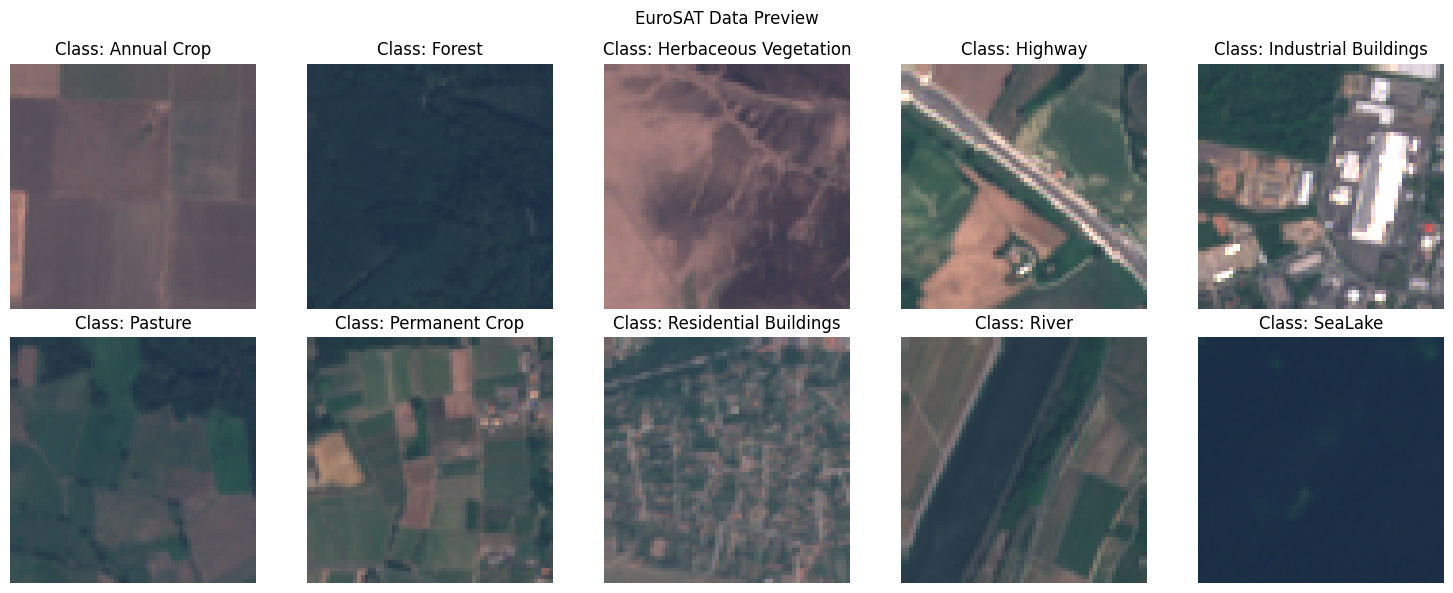

In [20]:
#Loading EuroSAT dataset from Hugging Face
dataset = load_dataset("blanchon/EuroSAT_RGB")

#Storing class names
label_names = dataset["train"].features["label"].names
print("Class labels:", label_names)

#Viewing Dataset (one image per class)
import matplotlib.pyplot as plt

seen_classes = set()
images_per_class = {}

#Looping through dataset and collecting one image per class
for item in dataset["train"]:
    label = item["label"]
    if label not in seen_classes:
        images_per_class[label] = item["image"]
        seen_classes.add(label)
    if len(seen_classes) == len(label_names):
        break

#Displaying one image per class
plt.figure(figsize=(15, 6))
for i, label in enumerate(sorted(images_per_class.keys())):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images_per_class[label])
    plt.title(f"Class: {label_names[label]}")
    plt.axis("off")

plt.suptitle("EuroSAT Data Preview")
plt.tight_layout()
plt.show()


**Preprocessing Data for Input into ResNET Model**

The dataset was first converted into Python lists of images and corresponding labels to ensure compatibility with PyTorch. I then split the data into training and validation sets to evaluate the model's generalization performance.


Before feeding the data into the ResNet18 model, I applied the required transformations, which included:

* Resizing each image to the appropriate input size
* Normalizing pixel values
* Converting the images into PyTorch tensors

These preprocessing steps ensured the input format was optimized for transfer learning using a pretrained convolutional neural network.





In [21]:

raw_dataset = load_dataset("blanchon/EuroSAT_RGB")["train"]

#Creating lists to store individual image-label pairs
images = []
labels = []

#Extracting each image-label pair in the dataset with a for loop
for ex in raw_dataset:
    img = ex["image"]        # Getting the image (PIL.Image)
    label = ex["label"]      # Getting the corresponding class label (0–9)

    #Unwrapping if image is stored as a single-item list [PIL.Image]
    if isinstance(img, list):
        img = img[0]

    images.append(img)
    labels.append(label)

In [22]:
#Splitting the data into training and validation sets
#Using stratified sampling to maintain class balance in both set

train_imgs, val_imgs, train_labels, val_labels = train_test_split(
    images,
    labels,
    test_size=0.2,
    stratify=labels,
    random_state=42
)


In [23]:
#Transforming images to be compatible with ResNet

#Resizing images to 224X224, converting to tensors, normalizing based on ImageNet
resnet_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [24]:
#Creating a PyTorch Dataset class from our image and class list
class EuroSATDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        label = torch.tensor(self.labels[idx], dtype=torch.long)  # Converting label to tensor (required for CrossEntropyLoss)

        if self.transform:
            img = self.transform(img)

        # Returning a dictionary with transformed image and label
        return {"image": img, "label": label}

In [26]:
#Wrapping the training data in a custom PyTorch Dataset
train_dataset = EuroSATDataset(train_imgs, train_labels, transform=resnet_transform)
val_dataset   = EuroSATDataset(val_imgs, val_labels, transform=resnet_transform)

#Creating DataLoaders to efficiently load data in batches
train_loader = DataLoader(
    train_dataset,
    batch_size=32,    #Number of samples per training batch
    shuffle=True      #Shuffling training data for better generalization
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32
)


In [27]:
#Checking one batch to ensure imaes are correctly batched and sized and the labels are the correct type (torch.long)
batch = next(iter(train_loader))

images = batch["image"]
labels = batch["label"]

print("Image batch shape:", images.shape)     #[32, 3, 224, 224]
print("Label batch dtype:", labels.dtype)     #torch.int64 (aka torch.long)
print("Label range:", labels.min().item(), "to", labels.max().item())  #0 to 9


Image batch shape: torch.Size([32, 3, 224, 224])
Label batch dtype: torch.int64
Label range: 0 to 9


**Loading the ResNET18 Model**

I loaded a pretrained ResNet18 model from PyTorch's torchvision.models,
leveraging the weights learned from the ImageNet dataset. To adapt the model for the EuroSAT classification task:

* I froze the early convolutional layers to retain their learned low-level feature representations.
* I replaced the final fully connected layer (fc) with a new layer that outputs predictions for the 10 EuroSAT land use classes.

This setup enabled transfer learning, allowing the model to focus training on the high level features specific to satellite imagery.



In [28]:
#Loading the ResNet18 model and pretrained ImageNet weights
weights = ResNet18_Weights.DEFAULT
model = resnet18(weights=weights)

#Freezing early layers of convolutional base
for param in model.parameters():
    param.requires_grad = False

#Replacing the final fully connected layer
model.fc = nn.Linear(model.fc.in_features, 10)  # 10 EuroSAT land cover classes


In [29]:
#Setting model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


In [30]:
# Defining the loss function
criterion = nn.CrossEntropyLoss()

# Defining the optimizer
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

**Training ResNet18 using Transfer Learning**

I trained the model for 10 epochs using the Adam optimizer and cross-entropy loss. During training, I tracked both training and validation accuracy at the end of each epoch.



In [31]:
#Training the model for a given number of epochs using the training DataLoader
def train_model(model, train_loader, criterion, optimizer, device, epochs=10):
    model.train()

    for epoch in range(epochs):
        running_loss = 0.0   #Accumulates loss for reporting
        correct = 0          #Counter for correct predictions
        total = 0            #Total number of samples processed

        #Adding progress bar to show training progress
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")

        #Iterating over each batch of training data
        for batch in loop:
            images = batch['image'].to(device)
            labels = batch['label'].to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            #Updating progress bar with current loss and accuracy
            loop.set_postfix(loss=loss.item(), acc=100 * correct / total)

        #Printing epoch summary
        print(f" Epoch {epoch+1} complete | Accuracy: {100 * correct / total:.2f}% | Loss: {running_loss:.4f}")


In [32]:
#training model
train_model(model, train_loader, criterion, optimizer, device, epochs=10)


Epoch 1/10: 100%|██████████| 405/405 [00:37<00:00, 10.92it/s, acc=80.4, loss=0.202]


 Epoch 1 complete | Accuracy: 80.45% | Loss: 269.3179


Epoch 2/10: 100%|██████████| 405/405 [00:38<00:00, 10.59it/s, acc=89.1, loss=0.234]


 Epoch 2 complete | Accuracy: 89.07% | Loss: 137.5091


Epoch 3/10: 100%|██████████| 405/405 [00:38<00:00, 10.46it/s, acc=90.6, loss=0.128]


 Epoch 3 complete | Accuracy: 90.65% | Loss: 115.1638


Epoch 4/10: 100%|██████████| 405/405 [00:41<00:00,  9.84it/s, acc=91.5, loss=0.464]


 Epoch 4 complete | Accuracy: 91.52% | Loss: 106.8487


Epoch 5/10: 100%|██████████| 405/405 [00:37<00:00, 10.91it/s, acc=91.9, loss=0.523]


 Epoch 5 complete | Accuracy: 91.93% | Loss: 97.9619


Epoch 6/10: 100%|██████████| 405/405 [00:36<00:00, 11.00it/s, acc=92.2, loss=0.108]


 Epoch 6 complete | Accuracy: 92.19% | Loss: 93.8823


Epoch 7/10: 100%|██████████| 405/405 [00:36<00:00, 10.95it/s, acc=92.4, loss=0.166]


 Epoch 7 complete | Accuracy: 92.43% | Loss: 89.7494


Epoch 8/10: 100%|██████████| 405/405 [00:39<00:00, 10.13it/s, acc=92.8, loss=0.106]


 Epoch 8 complete | Accuracy: 92.83% | Loss: 86.5776


Epoch 9/10: 100%|██████████| 405/405 [00:38<00:00, 10.41it/s, acc=92.9, loss=0.0937]


 Epoch 9 complete | Accuracy: 92.91% | Loss: 84.8465


Epoch 10/10: 100%|██████████| 405/405 [00:40<00:00, 10.04it/s, acc=93.1, loss=0.234]

 Epoch 10 complete | Accuracy: 93.15% | Loss: 78.1712


**Validating Model on Unseen Data**

After training, I computed the final validation accuracy to assess the model's performance on unseen data. The ResNet18 model achieved a 93% accuracy on the validation set, confirming its ability to generalize well to new satellite imagery across various land use and land cover categories.



In [36]:
#Evaluating the model on the validation dataset
def evaluate_model(model, val_loader, criterion, device, return_acc=False):
    model.eval()

#count of current predictions, total number of samples, accumulated loss
    correct = 0
    total = 0
    total_loss = 0

    #Inhibiting gradient tracking to save memory and compute
    with torch.no_grad():
        for batch in val_loader:
            images = batch["image"].to(device)
            labels = batch["label"].to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    #Calculating accuracy as a percentage
    accuracy = 100 * correct / total

    #Print the overall validation metrics
    print(f" Validation Accuracy: {accuracy:.2f}% | Loss: {total_loss:.4f}")




In [37]:
#validating model
val_acc = evaluate_model(model, val_loader, criterion, device, return_acc=True)


 Validation Accuracy: 93.09% | Loss: 20.1245


**Saving The Model**
The trained model was saved as a .pth file and deployed using FastAPI.

The deployment pipeline:

* Accepts uploaded satellite images

* Processes them through the trained ResNet18 model

* Returns the predicted land use classification for each image

* Generates a downloadable Excel (.xlsx) file containing image thumbnails,
filenames, and corresponding predicted labels.

This setup enables an end-to-end workflow from image ingestion to classification output.







In [38]:
torch.save(model.state_dict(), "eurosat_resnet18_finetuned.pth")
print("Model saved!")

from google.colab import files
files.download("eurosat_resnet18_finetuned.pth")


Model saved!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##Conclusion

This project demonstrates how transfer learning can be effectively applied to geospatial data for automating land use classification from satellite imagery. By leveraging a pretrained ResNet18 model and the EuroSAT dataset, I achieved high classification performance with minimal training from scratch.

This approach can be extended by:

* Incorporating additional land cover classes

* Integrating with real-time satellite feeds

* Further fine-tuning the model




